# Step 1: Imports

In [1]:
from typing import List, Tuple
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

def load_raw_data(filename: str) -> pd.DataFrame:
    mens_filepath = f"/kaggle/input/warmup-round-march-machine-learning-mania-2023/M{filename}.csv"
    weomens_filepath = f"/kaggle/input/warmup-round-march-machine-learning-mania-2023/W{filename}.csv"
    df_mens = pd.read_csv(mens_filepath)
    df_mens["Gender"] = "M"
    df_weomens = pd.read_csv(weomens_filepath)
    df_weomens["Gender"] = "W"
    return pd.concat([df_mens, df_weomens])

# Step 2: Load the data

In [2]:
RegularSeasonDetailedResults = load_raw_data("RegularSeasonDetailedResults")
RegularSeasonDetailedResults.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
70673,2023,127,3415,63,3142,54,N,0,20,56,2,10,21,30,11,23,9,14,5,2,22,17,43,4,13,16,21,1,21,5,15,7,2,24,W
70674,2023,127,3424,71,3361,68,H,0,23,55,2,12,23,33,10,23,12,14,7,6,16,28,58,5,10,7,10,7,24,12,13,4,1,26,W
70675,2023,127,3455,65,3378,53,A,0,24,51,6,13,11,13,2,28,14,11,7,2,12,19,60,4,22,11,13,8,22,11,12,2,6,12,W
70676,2023,127,3461,65,3161,56,H,0,25,57,5,17,10,16,13,35,15,14,3,2,13,21,55,9,24,5,8,1,20,12,8,8,4,17,W
70677,2023,127,3477,65,3230,62,A,0,23,50,3,13,16,19,12,20,10,9,6,0,11,22,51,8,22,10,12,8,15,12,9,5,1,13,W


In [3]:
NCAATourneyDetailedResults = load_raw_data("NCAATourneyDetailedResults")
NCAATourneyDetailedResults.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
755,2022,147,3163,91,3301,87,N,2,37,77,5,21,12,20,12,23,10,7,5,2,16,32,66,7,23,16,19,6,30,20,13,4,7,16,W
756,2022,147,3257,62,3276,50,N,0,25,58,5,15,7,9,6,20,12,11,15,4,17,16,46,3,14,15,20,10,24,9,21,6,2,12,W
757,2022,151,3163,63,3390,58,N,0,21,57,5,14,16,20,12,30,14,19,5,2,16,23,66,4,23,8,13,11,23,10,11,11,3,16,W
758,2022,151,3376,72,3257,59,N,0,27,57,6,17,12,17,8,24,19,14,11,4,11,27,63,1,8,4,7,11,18,5,15,13,2,17,W
759,2022,153,3376,64,3163,49,N,0,22,60,3,16,17,26,18,23,9,14,6,4,11,22,54,4,16,1,4,3,16,14,14,4,5,21,W


In [4]:
NCAATourneySeeds = load_raw_data("NCAATourneySeeds")
NCAATourneySeeds.tail()

,Season,Seed,TeamID,Gender
1535,2022,Z12,3125,W
1536,2022,Z13,3138,W
1537,2022,Z14,3110,W
1538,2022,Z15,3218,W
1539,2022,Z16,3107,W


# Step 3: Prepare the data



In [5]:
def process_detailed_results(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df = clean_detailed_results(df)
    df = aggregate_detailed_results(df)
    df = compute_percentages(df)
    return df

def clean_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(["WLoc", "DayNum"], axis=1)

def reshape_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    winner_columns, looser_columns = split_winner_and_looser_columns(df)
    df_winner = df.copy()
    df_winner = df_winner[winner_columns]
    df_winner.columns = clean_column_names(df_winner)
    df_winner["Win"] = 1
    df_looser = df.copy()
    df_looser = df_looser[looser_columns]
    df_looser.columns = clean_column_names(df_looser)
    df_looser["Win"] = 0
    return pd.concat([df_winner, df_looser], ignore_index=True)

def aggregate_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    df = reshape_detailed_results(df)
    df_agg = df.groupby(["Season", "TeamID"]).agg("mean")
    return df_agg.reset_index()

def compute_percentages(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df["FGP"] =  df["FGM"] / df["FGA"]
    df["FGP3"] =  df["FGM3"] / df["FGA3"]
    df["FTP"] =  df["FTM"] / df["FTA"]
    return df

def split_winner_and_looser_columns(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    winner_columns = [name for name in df.columns if not name.startswith("L")]
    looser_columns = [name for name in df.columns if not name.startswith("W")]
    return winner_columns, looser_columns

def clean_column_names(df: pd.DataFrame) -> List[str]:
    column_names = [
        name[1:] if 
        name.startswith("L") or name.startswith("W")
        else name 
        for name in df.columns
    ]
    return column_names

# Test data
test_df = pd.DataFrame([
    {"Season": 1, "WTeamID": "A", "LTeamID": "B", "stat1": 1, "Wstat2": 2, "Lstat2": 3 },
    {"Season": 1, "WTeamID": "A", "LTeamID": "B", "stat1": 4, "Wstat2": 5, "Lstat2": 6 },
])
expected_column_names = [
    "Season", "TeamID", "TeamID", "stat1", "stat2", "stat2"
]
expected_column_split = (
    ["Season", "WTeamID", "stat1", "Wstat2"], 
    ["Season", "LTeamID", "stat1", "Lstat2"]
)
expected_reshaped_df = pd.DataFrame([
    { "Season": 1, "TeamID": "A", "stat1": 1, "stat2": 2, "Win": 1 },
    { "Season": 1, "TeamID": "A", "stat1": 4, "stat2": 5, "Win": 1 },
    { "Season": 1, "TeamID": "B", "stat1": 1, "stat2": 3, "Win": 0 },
    { "Season": 1, "TeamID": "B", "stat1": 4, "stat2": 6, "Win": 0 },
    
])
expected_aggregated_df = pd.DataFrame([
    {"Season": 1, "TeamID": "A", "stat1": 2.5, "stat2": 3.5, "Win": 1.0 },
    {"Season": 1, "TeamID": "B","stat1": 2.5, "stat2": 4.5, "Win": 0.0 },
])
test_df_copy = test_df.copy()

# Tests
assert clean_column_names(test_df) == expected_column_names, "Function clean_column_names failed."
assert split_winner_and_looser_columns(test_df) == expected_column_split, "Function split_winner_and_looser_columns failed."
assert expected_reshaped_df.equals(reshape_detailed_results(test_df)), "Function reshape_detailed_results failed."
assert expected_aggregated_df.equals(aggregate_detailed_results(test_df)), "Function aggregate_detailed_results failed."

In [6]:
ProcessedRegularSeasonDetailedResults = process_detailed_results(
    RegularSeasonDetailedResults
)
ProcessedRegularSeasonDetailedResults.tail()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Win,FGP,FGP3,FTP
12130,2023,3473,54.640000,0.000000,19.760000,50.320000,6.400000,21.000000,8.720000,13.160000,6.360000,19.240000,11.880000,19.280000,6.320000,1.920000,16.040000,0.040000,0.392687,0.304762,0.662614
12131,2023,3474,57.115385,0.000000,20.038462,58.076923,4.423077,16.692308,12.615385,18.538462,8.461538,20.538462,6.538462,15.153846,7.230769,2.346154,21.192308,0.192308,0.345033,0.264977,0.680498
12132,2023,3475,62.384615,0.038462,21.807692,55.230769,4.423077,15.538462,14.346154,18.692308,9.000000,23.769231,13.000000,19.923077,7.538462,2.807692,18.538462,0.346154,0.394847,0.284653,0.767490
12133,2023,3476,59.178571,0.035714,21.571429,55.821429,6.178571,20.250000,9.857143,13.607143,8.678571,22.571429,14.000000,14.535714,3.892857,2.714286,14.964286,0.285714,0.386436,0.305115,0.724409
12134,2023,3477,64.838710,0.000000,23.064516,58.677419,3.677419,14.451613,15.032258,22.258065,11.483871,23.709677,11.838710,16.612903,8.064516,3.225806,15.580645,0.419355,0.393073,0.254464,0.675362


In [7]:
ProcessedNCAATourneyDetailedResults = process_detailed_results(
    NCAATourneyDetailedResults
)

ProcessedNCAATourneyDetailedResults.tail()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Win,FGP,FGP3,FTP
2034,2022,3426,71.0,0.0,27.0,62.0,7.0,16.0,10.0,16.0,7.0,26.0,11.0,9.0,6.0,5.0,20.0,0.0,0.435484,0.437500,0.625000
2035,2022,3428,74.0,0.0,27.5,53.5,10.5,25.5,8.5,12.0,6.0,25.5,16.5,17.5,3.0,1.5,14.5,0.5,0.514019,0.411765,0.708333
2036,2022,3437,55.0,0.0,20.5,58.5,6.0,23.5,8.0,12.0,7.5,19.5,11.0,10.0,8.5,5.0,18.0,0.5,0.350427,0.255319,0.666667
2037,2022,3439,81.0,0.0,30.0,60.0,6.0,17.0,15.0,20.0,7.0,28.0,13.0,10.0,1.0,1.0,13.0,0.0,0.500000,0.352941,0.750000
2038,2022,3450,40.0,0.0,14.0,56.0,3.0,22.0,9.0,14.0,8.0,31.0,5.0,17.0,2.0,2.0,23.0,0.0,0.250000,0.136364,0.642857


In [8]:
def process_seeds(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    mask = df["Season"] > 2002
    df = df[mask]
    df["Seed"] = df["Seed"].str.replace(r"\D+","")
    df["Seed"] = df["Seed"].astype(int)
    return df

In [9]:
ProcessedNCAATourneySeeds = process_seeds(NCAATourneySeeds)
ProcessedNCAATourneySeeds.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,Season,Seed,TeamID,Gender
1535,2022,12,3125,W
1536,2022,13,3138,W
1537,2022,14,3110,W
1538,2022,15,3218,W
1539,2022,16,3107,W


## Merge features

In [10]:
ProcessedNCAATourneyDetailedResults["Season"] += 1
features = pd.merge(
    ProcessedRegularSeasonDetailedResults,
    ProcessedNCAATourneyDetailedResults,
    how="inner",
    on=["Season", "TeamID"],
    suffixes=("Reg", "Tou")
)

features = features.merge(
    ProcessedNCAATourneySeeds,
    how="inner",
    on=["Season", "TeamID"]
)

features.tail()

,Season,TeamID,ScoreReg,NumOTReg,FGMReg,FGAReg,FGM3Reg,FGA3Reg,FTMReg,FTAReg,ORReg,DRReg,AstReg,TOReg,StlReg,BlkReg,PFReg,WinReg,FGPReg,FGP3Reg,FTPReg,ScoreTou,NumOTTou,FGMTou,FGATou,FGM3Tou,FGA3Tou,FTMTou,FTATou,ORTou,DRTou,AstTou,TOTou,StlTou,BlkTou,PFTou,WinTou,FGPTou,FGP3Tou,FTPTou,Seed,Gender
977,2022,3397,69.935484,0.064516,26.419355,63.580645,4.387097,14.451613,12.709677,19.838710,13.774194,29.354839,14.645161,16.677419,6.290323,5.967742,15.516129,0.741935,0.415525,0.303571,0.640650,71.0,0.0,27.0,62.50,2.0,13.00,15.0,19.0,17.0,29.00,10.00,18.00,7.50,7.0,15.50,0.50,0.432000,0.153846,0.789474,4,W
978,2022,3400,72.625000,0.093750,26.843750,61.937500,4.843750,13.531250,14.093750,20.156250,12.000000,21.125000,12.718750,13.875000,10.031250,3.593750,18.531250,0.812500,0.433401,0.357968,0.699225,62.5,0.0,22.5,59.25,5.5,16.75,12.0,16.5,12.0,22.25,9.75,10.75,5.25,2.0,15.25,0.75,0.379747,0.328358,0.727273,2,W
979,2022,3416,60.678571,0.000000,22.928571,55.714286,3.500000,11.071429,11.321429,15.821429,11.714286,21.535714,13.750000,14.928571,11.107143,3.464286,13.678571,0.892857,0.411538,0.316129,0.715576,51.0,0.0,21.0,57.00,3.0,13.00,6.0,12.0,13.0,22.00,10.00,19.00,5.00,2.0,22.00,0.00,0.368421,0.230769,0.500000,7,W
980,2022,3439,70.500000,0.031250,24.906250,56.343750,8.593750,23.656250,12.093750,15.937500,7.562500,25.125000,14.281250,12.531250,4.468750,3.500000,14.312500,0.718750,0.442041,0.363276,0.758824,59.0,0.0,21.0,56.00,6.5,20.00,10.5,12.5,6.5,19.50,14.00,14.00,5.50,1.5,18.00,0.50,0.375000,0.325000,0.840000,5,W
981,2022,3450,60.758621,0.034483,22.655172,58.344828,6.931034,21.551724,8.517241,11.896552,9.103448,21.689655,13.344828,13.482759,7.896552,4.172414,15.482759,0.655172,0.388298,0.321600,0.715942,53.0,0.0,17.0,55.00,8.0,25.00,11.0,12.0,8.0,24.00,11.00,11.00,6.00,4.0,15.00,0.00,0.309091,0.320000,0.916667,8,W


## Build Dataset

In [11]:
def get_outcomes(df):
    input_rows = df.to_records()
    output_rows = [parse_row(input_row) for input_row in input_rows]
    out_df = pd.DataFrame(output_rows)
    out_df = out_df[out_df["Season"] < 2017]
    return out_df

def parse_row(row):
    season = row['Season']
    winning_team_id = row['WTeamID']
    losing_team_id = row['LTeamID']
    if winning_team_id < losing_team_id:
        small_id = winning_team_id
        big_id = losing_team_id
        outcome = 1
    elif losing_team_id < winning_team_id:
        small_id = losing_team_id
        big_id = winning_team_id
        outcome = 0
    record = {
        "ID": f"{season}_{small_id}_{big_id}",
        'Season': season,
        'LowID': small_id,
        'HighID': big_id,
        'Win': outcome
    }
    return record

In [12]:
outcomes = get_outcomes(NCAATourneyDetailedResults)
print(outcomes.shape)
outcomes.tail()

(1355, 5)


,ID,Season,LowID,HighID,Win
1684,2016_3163_3400,2016,3163,3400,1
1685,2016_3124_3333,2016,3124,3333,0
1686,2016_3163_3333,2016,3163,3333,1
1687,2016_3393_3449,2016,3393,3449,1
1688,2016_3163_3393,2016,3163,3393,1


In [13]:
def merge_outcomes_with_features(outcomes: pd.DataFrame, features: pd.DataFrame) -> pd.DataFrame:
    data = pd.merge(
        outcomes, 
        features, 
        how="left", 
        left_on=["Season", "HighID"], 
        right_on=["Season", "TeamID"]
    )
    data = pd.merge(
        data, 
        features, 
        how="left", 
        left_on=["Season", "LowID"], 
        right_on=["Season", "TeamID"],
        suffixes=("High", "Low")
    )
    data.drop(
        ["Season", "HighID", "LowID","TeamIDHigh","TeamIDLow"], 
        axis=1, 
        inplace=True
    )
    data.set_index("ID", inplace=True)
    return data

In [14]:
data = merge_outcomes_with_features(outcomes, features)
print(data.shape)
data.tail()

(1355, 81)


,Win,ScoreRegHigh,NumOTRegHigh,FGMRegHigh,FGARegHigh,FGM3RegHigh,FGA3RegHigh,FTMRegHigh,FTARegHigh,ORRegHigh,DRRegHigh,AstRegHigh,TORegHigh,StlRegHigh,BlkRegHigh,PFRegHigh,WinRegHigh,FGPRegHigh,FGP3RegHigh,FTPRegHigh,ScoreTouHigh,NumOTTouHigh,FGMTouHigh,FGATouHigh,FGM3TouHigh,FGA3TouHigh,FTMTouHigh,FTATouHigh,ORTouHigh,DRTouHigh,AstTouHigh,TOTouHigh,StlTouHigh,BlkTouHigh,PFTouHigh,WinTouHigh,FGPTouHigh,FGP3TouHigh,FTPTouHigh,SeedHigh,GenderHigh,ScoreRegLow,NumOTRegLow,FGMRegLow,FGARegLow,FGM3RegLow,FGA3RegLow,FTMRegLow,FTARegLow,ORRegLow,DRRegLow,AstRegLow,TORegLow,StlRegLow,BlkRegLow,PFRegLow,WinRegLow,FGPRegLow,FGP3RegLow,FTPRegLow,ScoreTouLow,NumOTTouLow,FGMTouLow,FGATouLow,FGM3TouLow,FGA3TouLow,FTMTouLow,FTATouLow,ORTouLow,DRTouLow,AstTouLow,TOTouLow,StlTouLow,BlkTouLow,PFTouLow,WinTouLow,FGPTouLow,FGP3TouLow,FTPTouLow,SeedLow,GenderLow
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016_3163_3400,1,70.75000,0.0,26.15625,59.90625,4.4375,13.5000,14.00000,20.15625,13.56250,27.71875,14.09375,16.15625,7.78125,5.34375,18.90625,0.87500,0.436620,0.328704,0.694574,64.333333,0.0,26.0,60.666667,1.666667,11.333333,10.666667,15.0,14.0,25.666667,14.333333,17.0,4.333333,3.666667,15.666667,0.666667,0.428571,0.147059,0.711111,2.0,W,87.562500,0.0,34.34375,65.437500,7.562500,20.750000,11.312500,14.218750,12.875000,28.187500,21.625000,11.906250,12.187500,6.437500,11.250000,1.000000,0.524833,0.364458,0.795604,86.666667,0.0,33.166667,62.833333,9.0,22.166667,11.333333,14.833333,13.166667,28.333333,19.0,11.0,8.333333,7.00,10.833333,1.00,0.527851,0.406015,0.764045,1.0,W
2016_3124_3333,0,66.84375,0.0,24.84375,56.56250,6.5625,18.1875,10.59375,14.43750,12.00000,31.56250,15.37500,15.43750,5.09375,6.37500,14.12500,0.87500,0.439227,0.360825,0.733766,69.000000,0.0,22.5,52.500000,8.000000,23.000000,16.000000,23.0,9.5,24.500000,14.500000,15.0,8.500000,6.500000,17.000000,0.500000,0.428571,0.347826,0.695652,2.0,W,77.735294,0.0,30.00000,61.617647,3.470588,9.352941,14.264706,21.529412,14.617647,31.176471,20.794118,15.382353,8.705882,6.088235,14.794118,0.970588,0.486874,0.371069,0.662568,74.750000,0.0,28.500000,61.250000,3.0,9.000000,14.750000,18.750000,13.750000,31.500000,21.5,10.0,6.000000,6.25,12.500000,0.75,0.465306,0.333333,0.786667,1.0,W
2016_3163_3333,1,66.84375,0.0,24.84375,56.56250,6.5625,18.1875,10.59375,14.43750,12.00000,31.56250,15.37500,15.43750,5.09375,6.37500,14.12500,0.87500,0.439227,0.360825,0.733766,69.000000,0.0,22.5,52.500000,8.000000,23.000000,16.000000,23.0,9.5,24.500000,14.500000,15.0,8.500000,6.500000,17.000000,0.500000,0.428571,0.347826,0.695652,2.0,W,87.562500,0.0,34.34375,65.437500,7.562500,20.750000,11.312500,14.218750,12.875000,28.187500,21.625000,11.906250,12.187500,6.437500,11.250000,1.000000,0.524833,0.364458,0.795604,86.666667,0.0,33.166667,62.833333,9.0,22.166667,11.333333,14.833333,13.166667,28.333333,19.0,11.0,8.333333,7.00,10.833333,1.00,0.527851,0.406015,0.764045,1.0,W
2016_3393_3449,1,71.06250,0.0,24.84375,60.18750,7.0625,20.9375,14.31250,18.25000,10.18750,28.87500,11.50000,13.06250,7.21875,3.53125,13.75000,0.68750,0.412773,0.337313,0.784247,80.000000,0.0,28.0,69.000000,10.000000,29.000000,14.000000,19.0,10.0,30.000000,17.000000,6.0,2.000000,1.000000,23.000000,0.000000,0.405797,0.344828,0.736842,7.0,W,72.062500,0.0,25.46875,68.781250,8.875000,30.312500,12.250000,18.343750,17.281250,23.187500,13.437500,14.187500,13.062500,4.875000,17.750000,0.781250,0.370286,0.292784,0.667802,70.000000,0.0,24.500000,66.000000,7.0,23.500000,14.000000,22.000000,15.000000,23.500000,11.0,10.5,6.500000,4.00,21.000000,0.50,0.371212,0.297872,0.636364,4.0,W
2016_3163_3393,1,72.06250,0.0,25.46875,68.78125,8.8750,30.3125,12.25000,18.34375,17.28125,23.18750,13.43750,14.18750,13.06250,4.87500,17.75000,0.78125,0.370286,0.292784,0.667802,70.000000,0.0,24.5,66.000000,7.000000,23.500000,14.000000,22.0,15.0,23.500000,11.000000,10.5,6.500000,4.000000,21.000000,0.500000,0.371212,0.297872,0.636364,4.0,W,87.562500,0.0,34.34

## Train Test Split 

In [15]:
# For splitting data
from sklearn.model_selection import train_test_split

# Create train, validate, and test sets.
X = data.copy().drop("Win", axis=1)
y = data["Win"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

X_train.shape

(1016, 80)

In [16]:
def partition_features(df: pd.DataFrame, cardnality_threshold: int) -> Tuple[pd.DataFrame]:
    cat_cols = [name for name, data_type in df.dtypes.items() if data_type == object]
    num_cols = list(set(df.columns) - set(cat_cols))
    col_cardnality = {col_name: X_train[col_name].nunique() for col_name in cat_cols}
    cat_cols_high = []
    cat_cols_low = []
    for name, cardnality in col_cardnality.items():
        if cardnality > cardnality_threshold:
            cat_cols_high.append(name)
        else:
            cat_cols_low.append(name)
    return num_cols, cat_cols_high, cat_cols_low

In [17]:
num_cols, cat_cols_high, cat_cols_low = partition_features(X_train, 10)
print(num_cols)
print(cat_cols_high)
print(cat_cols_low)

['ScoreRegHigh', 'FGPRegLow', 'ORRegLow', 'FTMRegHigh', 'AstTouHigh', 'DRRegHigh', 'AstTouLow', 'TORegLow', 'FGP3RegLow', 'AstRegLow', 'FGM3TouHigh', 'FTPRegHigh', 'ScoreTouHigh', 'FTARegLow', 'DRTouHigh', 'FTMRegLow', 'FGA3RegLow', 'FTMTouLow', 'FGA3RegHigh', 'BlkTouHigh', 'FGPTouHigh', 'PFRegLow', 'FGATouLow', 'TORegHigh', 'DRTouLow', 'SeedHigh', 'WinTouLow', 'WinTouHigh', 'StlTouLow', 'FTARegHigh', 'WinRegLow', 'FTATouHigh', 'FGARegLow', 'WinRegHigh', 'SeedLow', 'FGARegHigh', 'FGMTouHigh', 'StlTouHigh', 'ORTouHigh', 'FGM3RegLow', 'PFTouLow', 'NumOTRegLow', 'PFRegHigh', 'FGPTouLow', 'FGP3RegHigh', 'FGA3TouLow', 'FGP3TouLow', 'DRRegLow', 'FGATouHigh', 'FTATouLow', 'ScoreRegLow', 'BlkTouLow', 'FTPRegLow', 'FGMRegLow', 'FGMRegHigh', 'FGA3TouHigh', 'FGM3TouLow', 'FTMTouHigh', 'ORRegHigh', 'TOTouHigh', 'PFTouHigh', 'ORTouLow', 'TOTouLow', 'FGMTouLow', 'FTPTouLow', 'BlkRegHigh', 'BlkRegLow', 'StlRegHigh', 'FGM3RegHigh', 'FTPTouHigh', 'FGPRegHigh', 'ScoreTouLow', 'AstRegHigh', 'NumOTRegHigh

### Data preperation pipelines

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy="median")

# Preprocessing for high cardnality categorical data
cat_high_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OrdinalEncoder(handle_unknown="ignore"))
])

# Preprocessing for low cardnality categorical data
cat_low_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_cols),
        ("cat_high", cat_high_transformer, cat_cols_high),
        ("cat_low", cat_low_transformer, cat_cols_low)
    ])

### Preprocess Data

In [19]:
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Step 4: Train a model


### Setup Hyperparameter Tuning
See https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, log_loss, brier_score_loss
from xgboost import XGBClassifier
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=Warning)

In [21]:
space={
    "n_estimators": hp.quniform("n_estimators", 250, 3000, 250),
    "learning_rate": hp.uniform("learning_rate", 0.1, 0.3),
    "max_depth": hp.quniform("max_depth", 2, 12, 1),
    "reg_lambda": hp.uniform("reg_lambda", 50, 250),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.05, 1),
    "tree_method": "gpu_hist",
    "random_state": 42
}

def objective(space):
    regressor=XGBClassifier(
        n_estimators = int(space["n_estimators"]),
        learning_rate = space["learning_rate"],
        max_depth = int(space["max_depth"]),
        reg_lambda = space["reg_lambda"],
        colsample_bytree = space["colsample_bytree"],
        tree_method = space["tree_method"],
        random_state = space["random_state"],
    )
    evaluation = [(X_train_processed, y_train), (X_valid_processed, y_valid)]
    regressor.fit(
        X_train_processed, y_train,
        eval_set=evaluation,
        eval_metric="auc",
        early_stopping_rounds=20,
        verbose=False
    )
    preds = regressor.predict(X_valid_processed)
    score = brier_score_loss(y_valid, preds)
    return {"loss": score, "status": STATUS_OK }

In [22]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

100%|██████████| 200/200 [00:48<00:00,  4.11trial/s, best loss: 0.28023598820059]


In [23]:
best_hyperparams

{'colsample_bytree': 0.3056669493543716,
 'learning_rate': 0.15880740777430427,
 'max_depth': 4.0,
 'n_estimators': 2250.0,
 'reg_lambda': 57.04856091612821}

Brier Score: 0.2949852507374631


<AxesSubplot:>

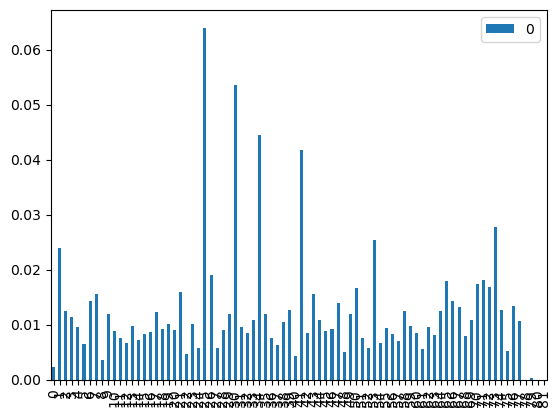

In [24]:
# Define model
model = XGBClassifier(
    n_estimators = int(best_hyperparams["n_estimators"]),
    max_depth = int(best_hyperparams["max_depth"]),
    learning_rate = best_hyperparams["learning_rate"],
    colsample_bytree = best_hyperparams["colsample_bytree"],
    reg_lambda = best_hyperparams["reg_lambda"], 
    tree_method = "gpu_hist",
    random_state = 42
)
model.fit(X_train_processed, y_train,
          early_stopping_rounds=20, 
          eval_set=[(X_valid_processed, y_valid)],
          verbose=False)
preds = model.predict(X_valid_processed)
print("Brier Score:", brier_score_loss(y_valid, preds))
pd.DataFrame(model.feature_importances_).plot.bar()

In the code cell above, we set `squared=False` to get the root mean squared error (RMSE) on the validation data.

# Step 5: Submit to the competition

We"ll begin by using the trained model to generate predictions, which we"ll save to a CSV file.

In [25]:
SampleSubmissionWarmup = pd.read_csv("/kaggle/input/warmup-round-march-machine-learning-mania-2023/SampleSubmissionWarmup.csv")

print(SampleSubmissionWarmup.shape)
SampleSubmissionWarmup.tail()

(614319, 2)


,ID,Pred
614314,2022_3469_3471,0.5
614315,2022_3469_3472,0.5
614316,2022_3470_3471,0.5
614317,2022_3470_3472,0.5
614318,2022_3471_3472,0.5


In [26]:
def get_submission_outcomes(sample_submission: pd.DataFrame) -> pd.DataFrame:
    df = sample_submission.copy()
    df.drop("Pred", axis=1, inplace=True)
    df[["Season", "LowID", "HighID"]] = df["ID"].str.split("_", expand=True)
    df[["Season", "LowID", "HighID"]] = df[["Season", "LowID", "HighID"]].astype(int)
    return df

In [27]:
submission_outcomes = get_submission_outcomes(SampleSubmissionWarmup)
print(submission_outcomes.shape)
submission_outcomes.tail()

(614319, 4)


,ID,Season,LowID,HighID
614314,2022_3469_3471,2022,3469,3471
614315,2022_3469_3472,2022,3469,3472
614316,2022_3470_3471,2022,3470,3471
614317,2022_3470_3472,2022,3470,3472
614318,2022_3471_3472,2022,3471,3472


In [28]:
X_submission = merge_outcomes_with_features(submission_outcomes, features)
print(X_submission.shape)
X_submission.tail()

(614319, 80)


,ScoreRegHigh,NumOTRegHigh,FGMRegHigh,FGARegHigh,FGM3RegHigh,FGA3RegHigh,FTMRegHigh,FTARegHigh,ORRegHigh,DRRegHigh,AstRegHigh,TORegHigh,StlRegHigh,BlkRegHigh,PFRegHigh,WinRegHigh,FGPRegHigh,FGP3RegHigh,FTPRegHigh,ScoreTouHigh,NumOTTouHigh,FGMTouHigh,FGATouHigh,FGM3TouHigh,FGA3TouHigh,FTMTouHigh,FTATouHigh,ORTouHigh,DRTouHigh,AstTouHigh,TOTouHigh,StlTouHigh,BlkTouHigh,PFTouHigh,WinTouHigh,FGPTouHigh,FGP3TouHigh,FTPTouHigh,SeedHigh,GenderHigh,ScoreRegLow,NumOTRegLow,FGMRegLow,FGARegLow,FGM3RegLow,FGA3RegLow,FTMRegLow,FTARegLow,ORRegLow,DRRegLow,AstRegLow,TORegLow,StlRegLow,BlkRegLow,PFRegLow,WinRegLow,FGPRegLow,FGP3RegLow,FTPRegLow,ScoreTouLow,NumOTTouLow,FGMTouLow,FGATouLow,FGM3TouLow,FGA3TouLow,FTMTouLow,FTATouLow,ORTouLow,DRTouLow,AstTouLow,TOTouLow,StlTouLow,BlkTouLow,PFTouLow,WinTouLow,FGPTouLow,FGP3TouLow,FTPTouLow,SeedLow,GenderLow
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022_3469_3471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022_3469_3472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022_3470_3471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022_3470_3472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022_3471_3472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
X_submission_processed = preprocessor.transform(X_submission)

In [30]:
# Use the model to generate predictions

predictions = model.predict(X_submission_processed)

# Save the predictions to a CSV file
output = pd.DataFrame({"ID": X_submission.index,
                       "Pred": predictions})
output.to_csv("submission.csv", index=False)
print(output.shape)
output

(614319, 2)


,ID,Pred
0,2017_1101_1102,0
1,2017_1101_1103,0
2,2017_1101_1104,0
3,2017_1101_1105,0
4,2017_1101_1106,0
...,...,...
614314,2022_3469_3471,0
614315,2022_3469_3472,0
614316,2022_3470_3471,0
614317,2022_3470_3472,0
